In [4]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from skimage.io import imread
import os
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras import optimizers, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import EfficientNetB0, ResNet50, DenseNet121
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve,  auc, ConfusionMatrixDisplay

from tensorflow.keras.applications import VGG16, VGG19, InceptionV3
from tensorflow.keras.utils import to_categorical

In [5]:
test = pd.read_csv('./aptos2019-blindness-detection/test.csv')
train = pd.read_csv('./aptos2019-blindness-detection/train.csv')

In [6]:
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
display(train.head())

Number of train samples:  3662
Number of test samples:  1928


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [7]:
train_modified = train.copy()

In [8]:
train_modified['diagnosis'] = train_modified['diagnosis'].apply(lambda x: 1 if x in [1, 2]
                                                                else (2 if x in [3, 4]
                                                                else 0))

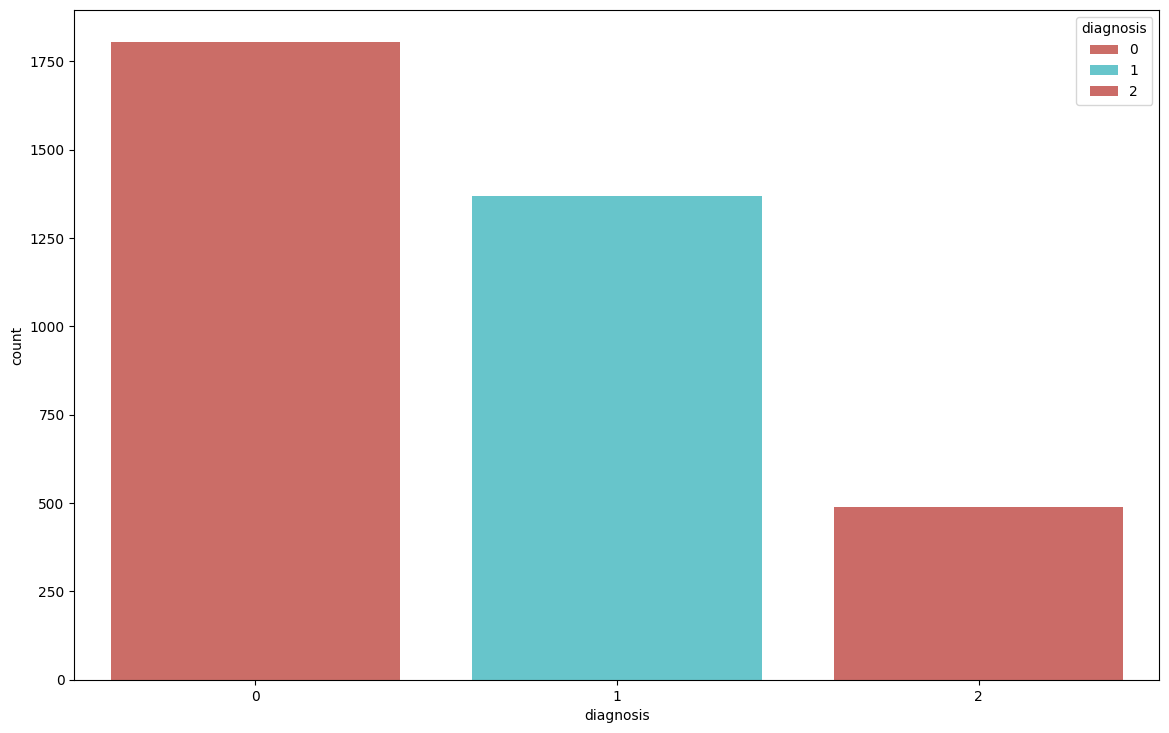

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(figsize=(14, 8.7))
sns.countplot(x='diagnosis', hue='diagnosis', data=train_modified, palette="hls", ax=ax)


plt.show()


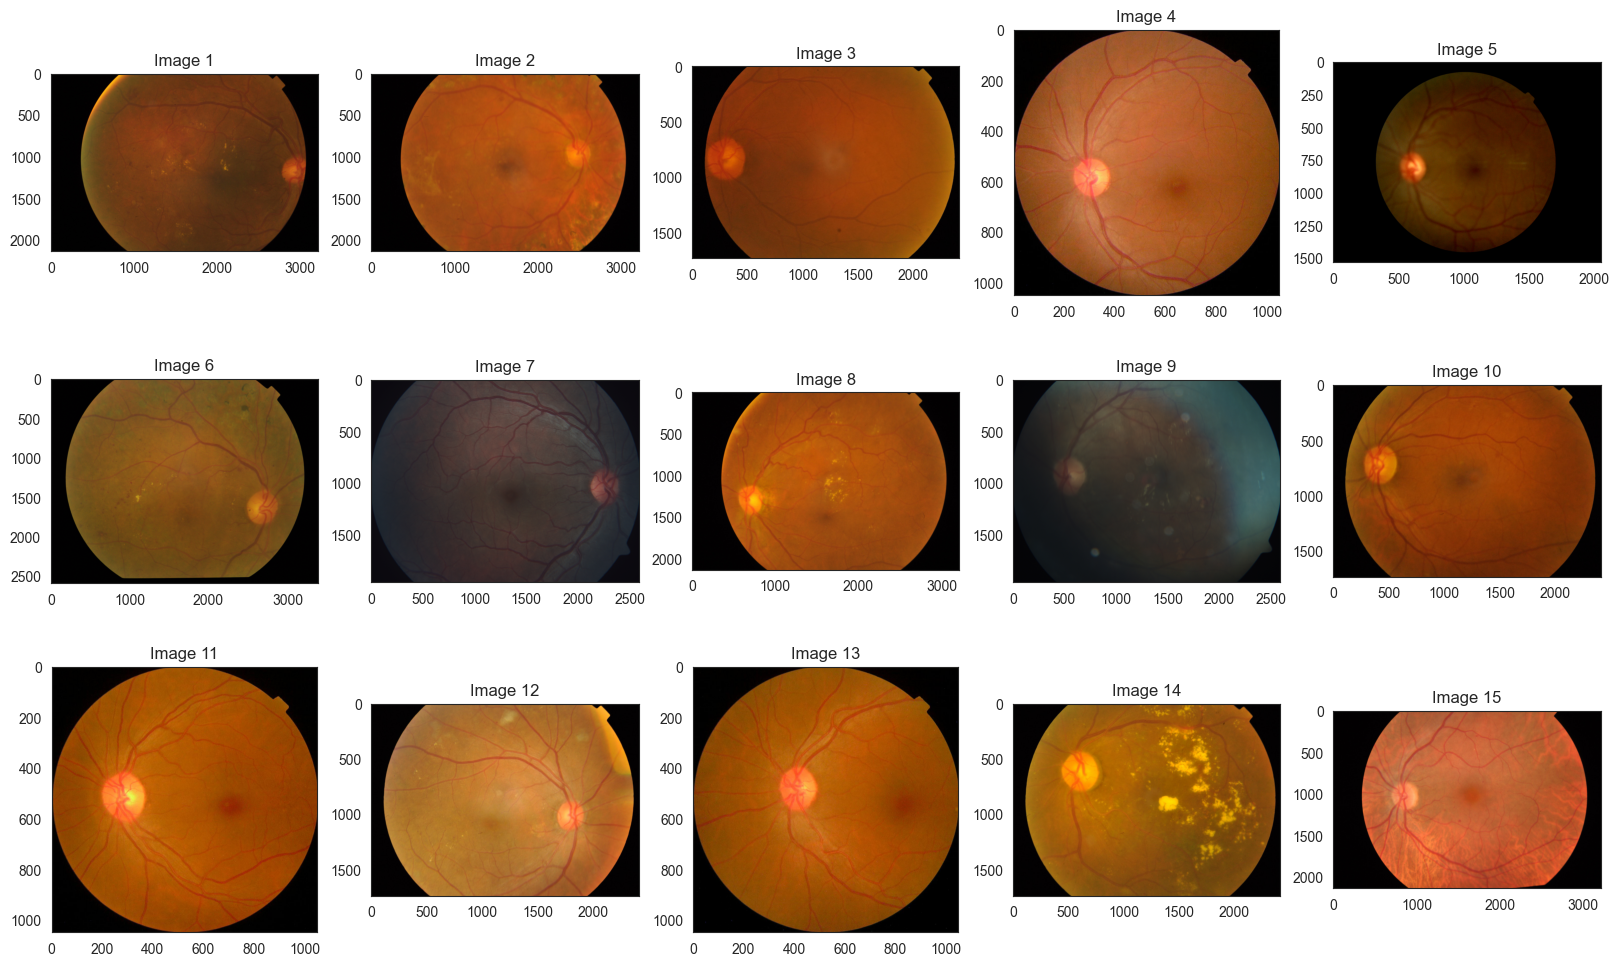

In [10]:
sns.set_style("white")
count = 1
plt.figure(figsize=[20, 20])
for img_name in train['id_code'][:15]:
    img = cv2.imread("./aptos2019-blindness-detection/train_images/%s.png" % img_name)[...,[2, 1, 0]]
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title("Image %s" % count)
    count += 1
    
plt.show()

In [11]:
print("Image IDs and Labels (TRAIN)")
train_df = pd.read_csv('./aptos2019-blindness-detection/train.csv')
train_df['id_code'] = train_df['id_code'] + ".png"

train_df['diagnosis'] = train_df['diagnosis'].apply(lambda x: 1 if x in [1, 2]
                                                    else (2 if x in [3, 4]
                                                    else 0))

print(f"Training images: {train_df.shape[0]}")
display(train_df.head())

print("Image IDs (TEST)")
test_df = pd.read_csv('./aptos2019-blindness-detection/test.csv')
test_df['id_code'] = test_df['id_code'] + ".png"
print(f"Testing Images: {test_df.shape[0]}")
display(test_df.head())


Image IDs and Labels (TRAIN)
Training images: 3662


,id_code,diagnosis
0,000c1434d8d7.png,1
1,001639a390f0.png,2
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


Image IDs (TEST)
Testing Images: 1928


,id_code
0,0005cfc8afb6.png
1,003f0afdcd15.png
2,006efc72b638.png
3,00836aaacf06.png
4,009245722fa4.png


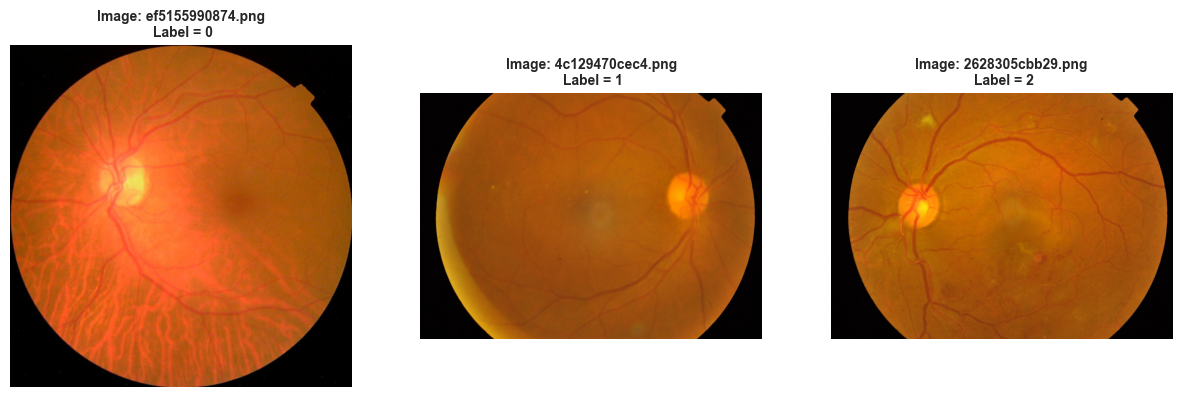

In [12]:
TRAIN_IMG_PATH = './aptos2019-blindness-detection/' + "train_images/"
SEED = 42
fig, ax = plt.subplots(1,3,figsize = (15,5))
for i in range(3):
    sample = train_df[train_df.diagnosis == i].sample(1,random_state=SEED)
    image_name = sample['id_code'].item()
    X = cv2.cvtColor(cv2.imread(f'{TRAIN_IMG_PATH}{image_name}'), cv2.COLOR_BGR2RGB)
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['diagnosis'].item()}", weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X)

In [13]:
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_eq = clahe.apply(l)
    lab_eq = cv2.merge((l_eq, a, b))
    return cv2.cvtColor(lab_eq, cv2.COLOR_LAB2RGB)

def apply_segmentation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return cv2.bitwise_and(image, image, mask=thresh)

def apply_gamma_correction(image, gamma=1.2):
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

In [14]:
def load_and_preprocess_image(image_id):
    image = cv2.imread(f'{TRAIN_IMG_PATH}{image_id}')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    image = apply_clahe(image)
    image = apply_segmentation(image)
    image = apply_gamma_correction(image)
    
    augmentations = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Affine(scale=(0.95, 1.05), translate_percent=(-0.05, 0.05), rotate=(-15, 15), p=0.5),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.3) 
    ])
    
    augmented = augmentations(image=image)
    image = augmented['image'] / 255.0  

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = (image - mean) / std
    
    return image

In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
df = pd.read_csv('./aptos2019-blindness-detection/train.csv')
df['id_code'] = df['id_code'].apply(lambda x: x + '.png')
df['diagnosis'] = df['diagnosis'].astype(str)

# Split dataset
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['diagnosis'], random_state=42)
IMG_SIZE = 224
BATCH_SIZE = 32
IMAGE_DIR = './aptos2019-blindness-detection/train_images/'

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    horizontal_flip=True,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGE_DIR,
    x_col='id_code',
    y_col='diagnosis',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=IMAGE_DIR,
    x_col='id_code',
    y_col='diagnosis',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 2929 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.


In [16]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [17]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [18]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['diagnosis'].astype(int)),
    y=train_df['diagnosis'].astype(int)
)
class_weights = dict(enumerate(class_weights))


In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    class_weight=class_weights,
    callbacks=callbacks
)


C:\Users\imthi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


In [7]:
model.save("file1.keras")

In [9]:
!pip install -q gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 32.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 95.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.3 MB/s eta 0:00:00


In [10]:
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_incep
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg
from PIL import Image

# Load your models
vgg_model = load_model("/kaggle/working/file1.keras")
inception_model = load_model("/kaggle/working/file1.keras")

# DR class labels
class_labels = {
    0: "No DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferative DR"
}

# Preprocess function (can use VGG's or Inception's - assume both use ImageNet scaling)
def preprocess_fundus_image(img):
    img = img.resize((224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    # Normalize using VGG/Inception scale
    return preprocess_vgg(img_array)

# Soft voting ensemble prediction
def predict_dr_level(image):
    img_processed = preprocess_fundus_image(image)

    pred_vgg = vgg_model.predict(img_processed)
    pred_incep = inception_model.predict(img_processed)

    ensemble_output = (pred_vgg + pred_incep) / 2
    predicted_class = int(np.argmax(ensemble_output))
    confidence = float(np.max(ensemble_output))

    return f"Prediction: {class_labels[predicted_class]} (Confidence: {confidence:.2f})"

# Gradio interface
gr.Interface(
    fn=predict_dr_level,
    inputs=gr.Image(type="pil", label="Upload Fundus Image"),
    outputs=gr.Text(label="Diabetic Retinopathy Prediction"),
    title="APTOS DR Detection — Ensemble Model",
    description="Upload a retinal fundus image to get the DR severity prediction (0–4)."
).launch(debug=True)


* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://b694e48157aedc8bce.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://b694e48157aedc8bce.gradio.live
